In [3]:
import pandas as pd
import time

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Read csv files
train_df = pd.read_csv("DailyDelhiClimateTrain.csv", parse_dates=True,index_col='date')
test_df = pd.read_csv("DailyDelhiClimateTest.csv", parse_dates=True,index_col='date')

#### Since we've done all the EDA in Linear_Regression and Autoregresive Notebooks we'll directly jump to the model building

Let's see if which hyperparameters are best for our model

In [21]:
# Set the frequency explicitly to daily ('D')
train_df = train_df.asfreq('D')
X_train = train_df['meantemp']

p_ = range(0, 29, 4) # lags 
q_ = range(0, 5) # residuals

mae_dict =  {}
for p in p_:
    mae_dict[p] = []
    for q in q_:
        # (p, d, q)
        # Where d is the number of differencing required to make the time series stationary.
        order = (p, 0, q)
        # let's see what time it takes to train each set of hyperparameters
        start_time = time.time()
        # fit the model
        model = ARIMA(X_train, order=order).fit()
        # get elapsed time
        elapsed = time.time() - start_time
        # get_predictions
        pred = model.predict()
        # get the Mean Squared Error for each set of hyperparameters
        mae = mean_absolute_error(X_train, pred)
        mae_dict[p].append(mae)
        print(f'{order} took {elapsed} seconds')


(0, 0, 0) took 0.47850704193115234 seconds
(0, 0, 1) took 0.7290689945220947 seconds
(0, 0, 2) took 1.2055869102478027 seconds
(0, 0, 3) took 1.5931429862976074 seconds
(0, 0, 4) took 1.336883783340454 seconds
(4, 0, 0) took 1.674980878829956 seconds
(4, 0, 1) took 3.325113534927368 seconds
(4, 0, 2) took 3.784268856048584 seconds
(4, 0, 3) took 4.963956117630005 seconds
(4, 0, 4) took 6.809452056884766 seconds
(8, 0, 0) took 6.1965858936309814 seconds
(8, 0, 1) took 9.624533891677856 seconds
(8, 0, 2) took 9.452949285507202 seconds
(8, 0, 3) took 14.554935693740845 seconds
(8, 0, 4) took 15.67758822441101 seconds
(12, 0, 0) took 6.698889493942261 seconds
(12, 0, 1) took 5.0459465980529785 seconds
(12, 0, 2) took 6.787212133407593 seconds
(12, 0, 3) took 8.491490840911865 seconds
(12, 0, 4) took 14.08377742767334 seconds
(16, 0, 0) took 8.779295444488525 seconds
(16, 0, 1) took 15.744637250900269 seconds
(16, 0, 2) took 18.833277702331543 seconds
(16, 0, 3) took 22.06734871864319 secon

In [23]:
# Put our findings into a dataframe
mae_df = pd.DataFrame(mae_dict)
mae_df

,0,4,8,12,16,20,24,28
0,6.362671,1.231178,1.225520,1.226056,1.225962,1.221609,1.212815,1.213977
1,3.660689,1.227950,1.227584,1.226080,1.215009,1.209851,1.213022,1.214061
2,2.596784,1.226385,1.225888,1.226323,1.205452,1.222745,1.212997,1.208292
3,2.114020,1.226204,1.222505,1.226463,1.222953,1.210189,1.203306,1.217994
4,1.877519,1.226989,1.224228,1.226541,1.225267,1.211004,1.202648,1.200346


In [26]:
# Find the minimum value in the entire DataFrame
min_value = mae_df.min().min()

# Get the row and column index of the minimum value
# Use `unstack` to reshape the DataFrame and find the index of the min value
min_location = mae_df.unstack().idxmin()

# Separate the row index and column name
p, q = min_location

print(f"Lowest MAE: {min_value}")
print(f"Best hyperparemeters p:{p} , q:{q}")

Lowest MAE: 1.2003463291448946
Best hyperparemeters p:28 , q:4


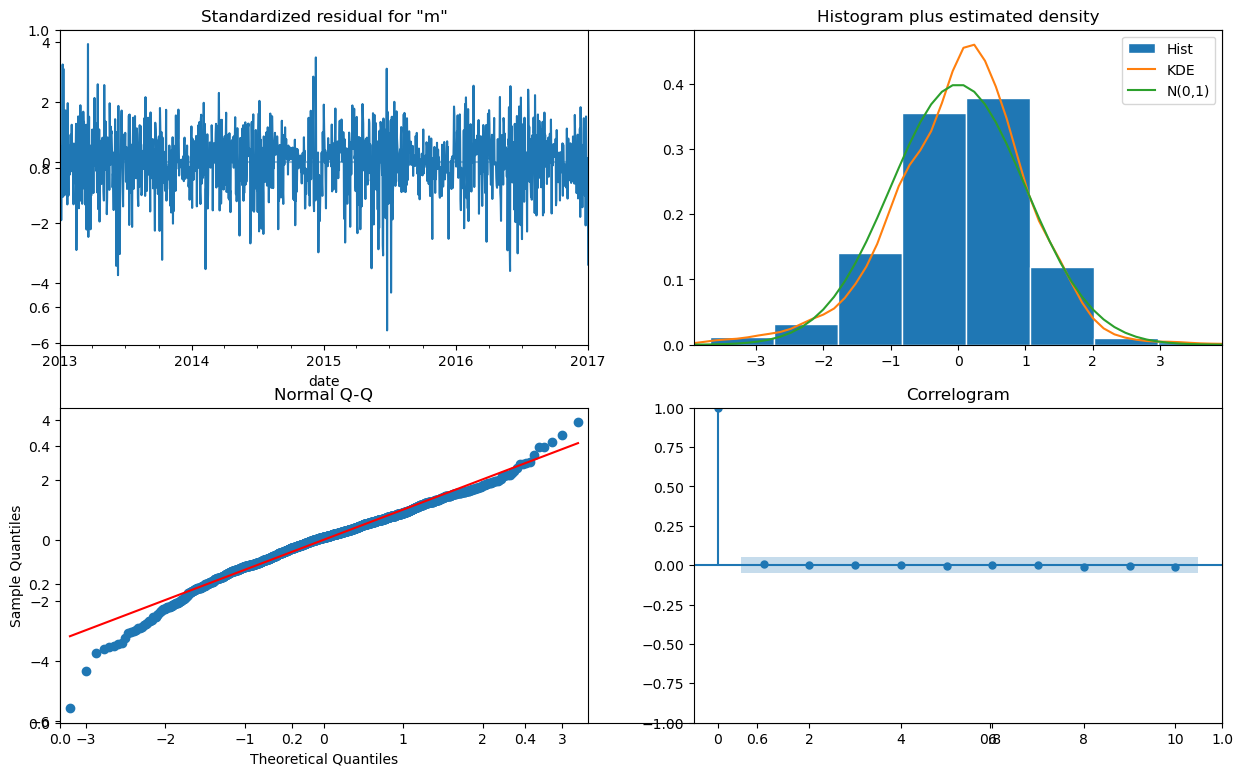

In [29]:
fig, ax = plt.subplots(figsize=(15, 9))
model.plot_diagnostics(fig = fig);

In [44]:
# perfom a walk foward validatiion on ARIMA model with the best set of hyperparameters
# We'll not use the (24, 0, 2) model since it's resource intensive.
# instead we'll use the (16,0,2) model wich train will almost 1/4 the time of the (24,0,2) model and has a mae of 1.205452

# Set the frequency explicitly to daily ('D')
test_df = test_df.asfreq('D')


X_test = test_df['meantemp']
pred_wfv = []
history = list(X_train) # make history a list since python 3 does not support appending to Series
for i in range(len(X_test)):
    try:
        # Fit mode with history such that the last value in history will predict the next value
        model = ARIMA(history, order = (16,0,2))
        model.initialize_approximate_diffuse() # This is to prevent the error: LU decomposition error.
        model = model.fit()
        # Preduct the next value from history
        next_pred = model.forecast()
        # Append value to predicted walk forward validation 
        # Since model.forecast() returns a numpy array, we need to extract the value from the array
        pred_wfv.append(next_pred[0])
        #Append X_test to history to make the model ready for the next prediction
        history.append(X_test.iloc[i])

    except Exception as e:
        print(f'An error occured in model fitting {e}')
        

# Convert predictions to Pandas Series (if needed)
pred_wfv = pd.Series(pred_wfv, index=X_test.index)
print(pred_wfv)

date
2017-01-01    11.535124
2017-01-02    15.794084
2017-01-03    18.155550
2017-01-04    16.194706
2017-01-05    17.845060
                ...    
2017-04-20    33.074472
2017-04-21    33.757018
2017-04-22    33.667151
2017-04-23    32.865596
2017-04-24    32.869157
Freq: D, Length: 114, dtype: float64


In [45]:
## Re_calculate the MAE again
test_MAE = mean_absolute_error(X_test, pred_wfv)
print((test_MAE))

#We beat the baseline!

1.3546804833869133


In [46]:
df_pred_test = pd.DataFrame(
    {
    'test_df': X_test,
    'pred_wfv': pred_wfv
    }
)
fig = px.line(df_pred_test, labels = {'value': 'meantemp'})
fig.show()

### Model is doing a good job in predicting the future 
#### However the ARIMA Model is resource intensive and takes a lot of time to train, as compared to the other models ie:
#### Linear Regression,  and Autoregressive Model

#### Thue if we were to predict the other features of the data, we would have to use either the Linear Regression Model or the Autoregressive Model